!pip install somoclu

In [1]:
import fitsio
from astropy.io import fits
import numpy as np
import somoclu
import matplotlib as mpl
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import tqdm

mpl.rcParams['figure.dpi'] = 200

In [2]:
import sys
sys.path.append('../sources')
from cat2som import *
from OR_weights import *
import plot_som
from plot_som import *


# Prepare the data 

Download the bright sample catalog made by Harry Johnston from KiDS lensing wiki: https://lensingkids.strw.leidenuniv.nl/doku.php?id=kids-1000#kids-1000_gama-like_bright_galaxy_catalogue

Now we creat a smaller subsample of the catalog to make the work faster:

In [3]:
kids_brightsample = fitsio.FITS('/net/home/fohlen13/yanza21/DATA/KiDS_data/DR4_syst_cat_cleaned_ANNzBright.fits')

# Data preprocessing

In [17]:
#columns_selected = ['MU_THRESHOLD', 'psf_fwhm', 'psf_ell', 'MAG_LIM_r', 'EXTINCTION_r', 'gaia_pixel_nstar']  # columns to be read from the catalog
#columns_syst = ['MU_THRESHOLD', 'psf_fwhm', 'psf_ell', 'MAG_LIM_r', 'EXTINCTION_r', 'gaia_pixel_nstar']  # columns to be used for the training (can be different from columns_selected because some columns may be mixed up)

columns_selected = ['MU_THRESHOLD', 'psf_fwhm', 'psf_ell']  # columns to be read from the catalog
columns_syst = ['MU_THRESHOLD', 'psf_fwhm', 'psf_ell']  # columns to be used for the training (can be different from columns_selected because some columns may be mixed up)
column_edges = np.array([[20,30], [0, 10], [0,2],  [20, 30], [-1,1], [0,10]])  # prior boundaries of each column, used for excluding outliers

n_syst= len(columns_syst)

raw_data = []

for key in columns_selected:
    raw_data.append(kids_brightsample[1][key][:].tolist())
raw_data = np.array(raw_data).T

radec = np.array(kids_brightsample[1]['ALPHA_J2000', 'DELTA_J2000'][:].tolist())  # read RA and Dec

### excluding outliers ###

outliers = np.zeros(raw_data.shape[0])
for i in range(raw_data.shape[1]):
    l = raw_data.T[i]
        
    dist_to_mean = l - l.mean()
    std = np.std(l[~np.isnan(l)])
    
    outliers += np.logical_or(l<column_edges[i][0], l>column_edges[i][1])    
    outliers += np.logical_or(l==+np.inf, l==-np.inf)
    outliers += np.isnan(l)

radec_edges = np.array([[0,360], [-90, 90]])
radec = np.round(radec,3)

for i in range(2):
    radec_i = radec.T[i]
    outliers += np.isnan(radec_i)
    outliers += np.logical_or(radec_i<radec_edges[i][0], radec_i>radec_edges[i][1])    
    outliers += np.logical_or(radec_i==+np.inf, radec_i==-np.inf)
    
invalid_ind = np.where(outliers>0)[0]

radec = np.delete(radec, invalid_ind, axis=0)

raw_data = np.delete(raw_data, invalid_ind, axis=0)
raw_data_raw = raw_data.copy()
raw_data = (raw_data - np.min(raw_data, axis=0)) / (np.max(raw_data, axis=0)-np.min(raw_data, axis=0))

In [5]:
Ns = 256

training_data = raw_data[:int(len(raw_data)/2)]

testing_data = training_data #raw_data[int(len(raw_data)/2):]
testing_radec = radec[:int(len(raw_data)/2)] #radec[int(len(raw_data)/2):]
source_hp_ind = hp.ang2pix(Ns, testing_radec.T[0], testing_radec.T[1], lonlat=True)

# Train the SOM

In [6]:
som_dim = int((raw_data.shape[0]**0.5*5)**0.5)
topology = 'hexagonal'
som = somoclu.Somoclu(som_dim, som_dim, gridtype=topology, maptype='toroid',
                      compactsupport=True, initialization='pca')
%time som.train(training_data[:])

CPU times: user 31min 12s, sys: 37.3 s, total: 31min 49s
Wall time: 24.8 s


In [7]:
from pathos.pools import ProcessPool
#from multiprocess import Pool

def get_bmus(som, data, step=1000):
    '''
    This function gets the "best matching unit (bmu)" of a given data on a pre-trained SOM.
    It works by multiprocessing chunks of the data.
    Input:
    som: a pre-trained Somoclu object;
    data: np.ndarray of the data vector;
    step: int, the size of a chunk of the data.
    '''

    def func(i):
        if i * step + step > len(data):
            dmap = som.get_surface_state(data[i*step:])
            bmus = np.zeros((step, 2))
            bmus[:len(data)-i*step] = som.get_bmus(dmap).tolist()
            return bmus
        else:
            dmap = som.get_surface_state(data[i*step:i*step+step])
            return som.get_bmus(dmap).tolist()
    with ProcessPool() as p:
        bmus = p.map(func, np.arange(int(len(data)/step)+1))
    bmus_array = np.asarray(bmus).astype(np.int)
    return bmus_array.reshape(bmus_array.shape[0]*bmus_array.shape[1], 2)[:len(data)]


# Analyse the som

In [8]:
import sklearn.cluster as sc
n_cluster = 100
algorithm1 = sc.AgglomerativeClustering(n_clusters=n_cluster)

#algorithm1 = sc.KMeans(n_clusters=n_cluster)

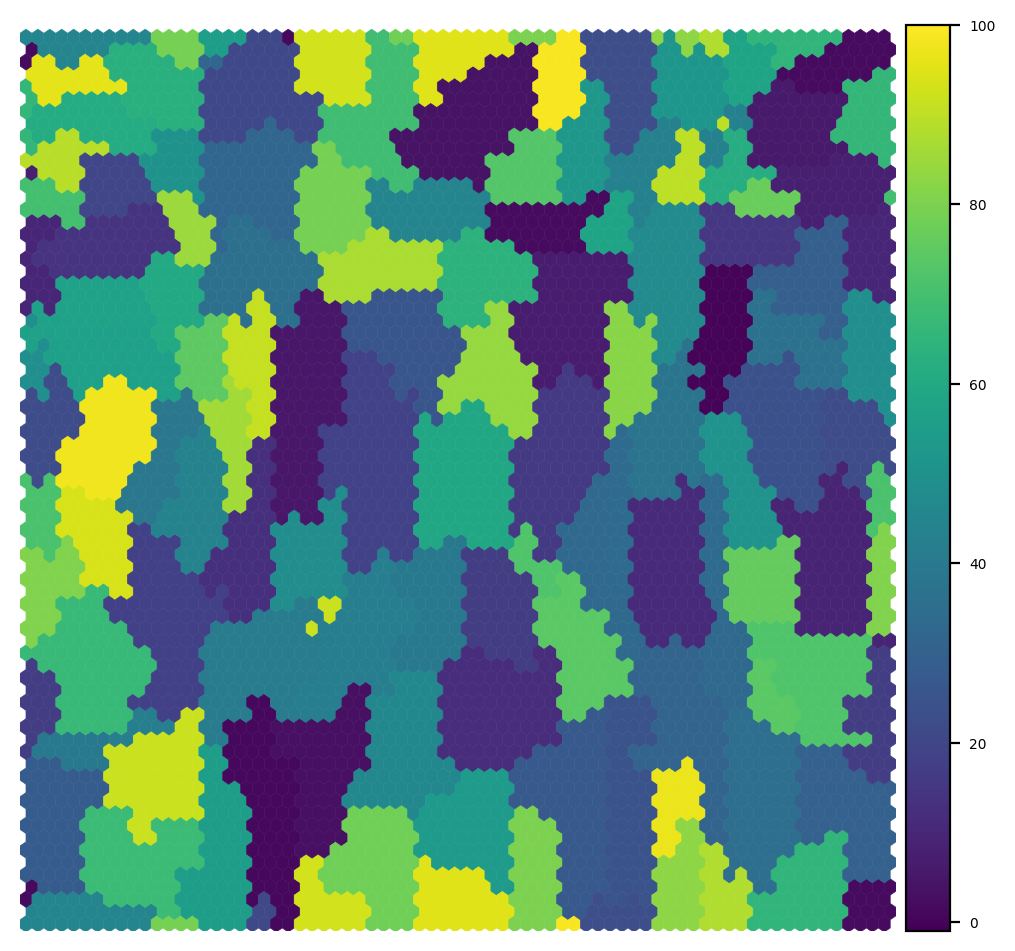

In [9]:
som.cluster(algorithm1)
som_cluster_ind1d = som.clusters.reshape(-1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
plot_som(ax, som.clusters, topology=topology, colormap=cm.viridis, cbar_name=None, vmin=-1, vmax=n_cluster)

In [10]:
def som_ind_to_1d(xi, yi, som_dim):
        '''
        This function converts the 2-D indices of a SOM into a 1-D index of the flattend
        SOM. 
        Input:
        xi, yi: integers of the indices of a SOm
        '''
        return xi * som_dim + yi

In [11]:
#winner_x, winner_y = som.bmus.T  # the x and y indices on the SOM of bmu of each source
winner_x, winner_y = get_bmus(som, testing_data).T  # for testing
winner_ind1d = som_ind_to_1d(winner_x, winner_y, som_dim)

source_cluster_ind1d = np.zeros_like(winner_ind1d)
for i in range(winner_ind1d.size):
    source_cluster_ind1d[i] = som_cluster_ind1d[winner_ind1d[i]]

# Get the distribution of systematics on the SOM

In [12]:
sys_maps = np.zeros((som_dim, som_dim, testing_data.shape[1]))
n_maps = np.zeros((som_dim, som_dim))

for i in range(len(testing_data)):
    sys_maps[winner_x[i], winner_y[i]] += testing_data[i]
    n_maps[winner_x[i], winner_y[i]] += 1

fig = plt.figure(figsize=(6,6))
_hexplot(sys_maps[:,:,3]/n_maps, fig, cm.coolwarm)


import plot_som
from importlib import reload
reload(plot_som)
from plot_som import *

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
plot_som(ax, sys_maps[:,:,3]/n_maps, topology='hex', colormap=cm.coolwarm, cbar_name=None)

som.cluster(algorithm1)
som_cluster_ind1d = som.clusters.reshape(-1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
plot_som(ax, sys_maps[:,:,2]/n_maps, topology='hex', colormap=cm.viridis, cbar_name=None)

In [13]:
def calculate_or_weights(Ns, som_dim, source_hp_ind, source_cluster_ind, som_cluster_ind1d):

    '''
    This function calculates the organized random weight on the pixelized sky.
    Input:
    Ns: an integer specifying the Nside of the weight map.
    som_dim: the dimension of the SOM;    
    source_hp_ind,: the healpix indices of each source in the catalog;
    source_cluster_ind: the cluster indices of each source in the testing data.
    som_cluster_ind1d: the cluster indices of each cell in the SOM
    Output:
    weight_map: a healpix map of the organized random weight
    number_contrast: a 2-D matrix of number_contrast in each cell of the SOM
    '''
    
    source_hp_ind_unique, n_p = np.unique(source_hp_ind, return_counts=True)  # this line gives the unique healpix pixel indices that contains at least one galaxy, as well as the number of galaxies in each pixel 
    A_p = hp.nside2pixarea(Ns) * source_hp_ind_unique.size  # the total area of the footprint

    delta_i_sum = 0
    weight_map = np.zeros(hp.nside2npix(Ns))
    number_contrast = np.zeros(som_dim**2)
    
    for cluster_ind in range(source_cluster_ind.max()):
        source_clusteri_ind = np.where(source_cluster_ind==cluster_ind)[0]  # pick out the catalog indices of sources that are in the cluster_ind'th hierarchical cluster
        n_i = source_clusteri_ind.size  # and the number of sources in that cluster
        source_hp_ind_i = source_hp_ind[source_clusteri_ind]  # and the Healpix pixel indices
        source_hp_ind_clusteri_unique, n_p_i = np.unique(source_hp_ind_i, return_counts=True)  # n_p_i is the number of sources that are in the i-th cluster in each Healpix pixel
        A_i = 0
        for p, hp_ind in enumerate(source_hp_ind_clusteri_unique):
            A_i += n_p_i[p]/n_p[np.where(source_hp_ind_unique==hp_ind)[0]] * hp.nside2pixarea(Ns)
        #A_p_i = n_p_i/n_p[np.intersect1d(source_hp_ind_unique, source_hp_ind_clusteri_unique, return_indices=True)[1]] * hp.nside2pixarea(Ns)  # the effective pixel area for the i-th SOM cell
        #A_i = np.sum(A_p_i)  # the total effective area for the i-th SOM cell
        delta_i = n_i / A_i  # effective number density 
        #som_ind = testing_som_ind[som_cluster_ind1d==cluster_ind]
        number_contrast[som_cluster_ind1d==cluster_ind] = delta_i
        delta_i_sum += delta_i
        weight_map[source_hp_ind_clusteri_unique] += delta_i * n_p_i  # weight of each Healpix pixel
    
    weight_map/=np.mean(delta_i_sum)
    weight_map[weight_map==0] = hp.UNSEEN
    number_contrast = number_contrast.reshape(som_dim, som_dim)
    return weight_map, number_contrast

In [14]:
N_gal_tot = len(testing_data)
A_gal_tot = hp.nside2pixarea(Ns) * np.unique(source_hp_ind).size
n_gal_mean = N_gal_tot / A_gal_tot

weight_map, ncontrast_som = calculate_or_weights(Ns, som_dim, source_hp_ind, source_cluster_ind1d, som_cluster_ind1d)

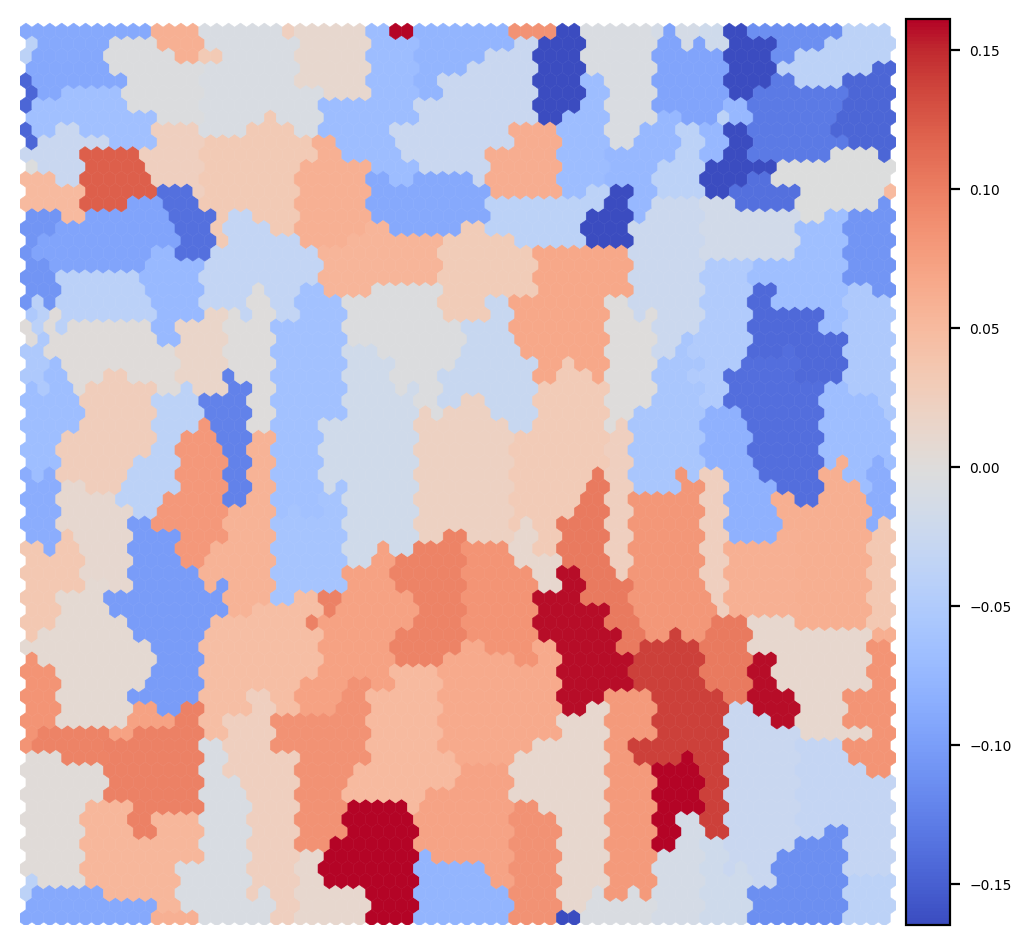

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
plot_som(ax, ncontrast_som/n_gal_mean-1, topology=topology, colormap=cm.coolwarm, cbar_name=None)

/net/home/fohlen13/yanza21/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


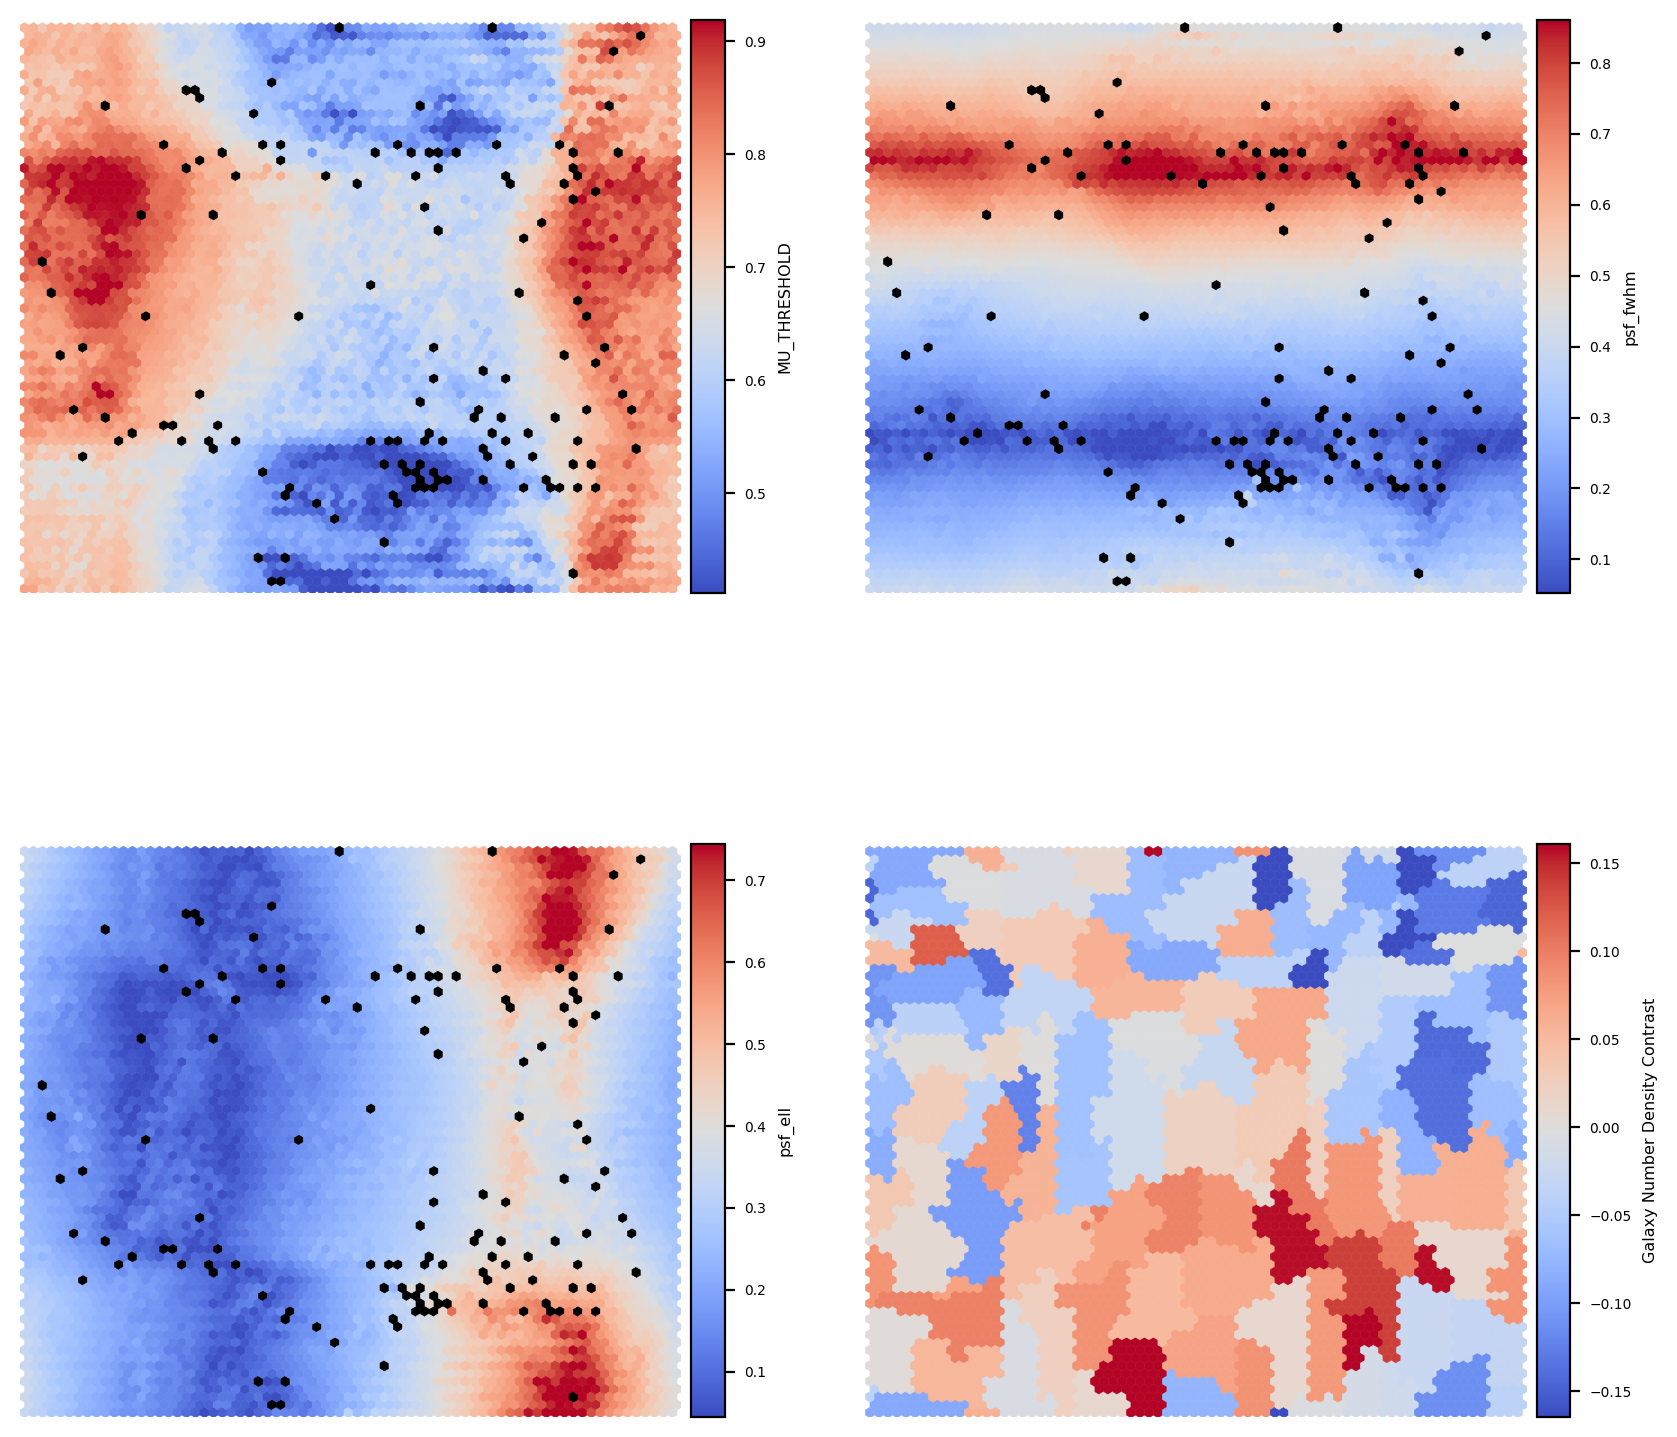

In [19]:
import matplotlib.pyplot as plt

import plot_som
from importlib import reload
reload(plot_som)
from plot_som import *

f, axes = plt.subplots(ncols=2, nrows=int(n_syst/2)+1, figsize=(10,10*2/(int(n_syst/2)+1)))
#plt.subplots_adjust(wspace=0.03, hspace=0.03)

for i in range(n_syst):
    ax = axes.flatten()[i]
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    plot_som(ax, sys_maps[:,:,i]/n_maps, topology=topology, colormap=cm.coolwarm, cbar_name=columns_syst[i])
    
ax = axes.flatten()[-1]
ax.set_aspect('equal')
plot_som(ax, ncontrast_som/n_gal_mean-1, topology=topology, colormap=cm.coolwarm, 
         cbar_name='Galaxy Number Density Contrast')
ax.set_xticks([])
ax.set_yticks([])

if n_syst % 2 == 0:
    axes.flatten()[-2].set_visible(False)

# Plot the organized random weights

In [ ]:
lonran=[125, 240]
latran=[-5,4]
mn=hp.cartview(weight_map, return_projected_map=True, lonra=lonran, latra=latran)

In [ ]:
lonras=[-31, 55]
latras=[-37,-26]
ms=hp.cartview(weight_map, return_projected_map=True, lonra=lonras, latra=latras)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(nrows=2, figsize=(15,4))
#plt.subplots_adjust(hspace=0.5)
#plt.axis('scaled')

plt.axes(axes[0])
plt.axis([lonran[0],lonran[1],latran[0],latran[1]], 'scaled')
axes[0].set_anchor('W')
plt.imshow(mn, extent=(lonran[0],lonran[1],latran[0],latran[1]), origin='lower', vmin=0, vmax=25)
plt.title('KiDS-North')
#plt.colorbar(label='OR weight')
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)

plt.axes(axes[1])
plt.axis([lonras[0],lonras[1],latras[0],latras[1]], 'scaled')
axes[1].set_anchor('W')
scmap = plt.imshow(ms, extent=(lonras[0],lonras[1],latras[0],latras[1]), origin='lower', vmin=0, vmax=25)
plt.title('KiDS-South')
#plt.colorbar(label='OR weight')
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size="1%", pad=1)       
cb = plt.colorbar(scmap, cax=cax)
cb.ax.tick_params(labelsize=5)
cb.set_label('OR weight', size='xx-small') 



## Plot the spatial distribution of each systematics

In [ ]:
fig, axes = plt.subplots(nrows=raw_data.shape[1]*2, figsize=(15,15))
plt.subplots_adjust(hspace=0.5)

for sys_ind in range(raw_data.shape[1]):
    #sys_ind = 1
    plt.axes(axes[sys_ind*2])
    plt.axis('scaled')
    axes[sys_ind*2].set_anchor('W')
    #hp.cartview(np.ones_like(weight_map)*hp.UNSEEN, lonra=[-31, 55], latra=[-37,-26], title='KiDS-South, '+columns_syst[sys_ind], flip='geo', cbar=None)
 
    plt.scatter(testing_radec.T[0], testing_radec.T[1], c=testing_data.T[sys_ind], cmap='coolwarm', s=0.1, marker='s',
                   vmin=np.quantile(testing_data.T[sys_ind],0.01), vmax=np.quantile(testing_data.T[sys_ind], 0.99))
    plt.title(columns_syst[sys_ind], fontsize=10)
    plt.xlim(125, 240)
    if sys_ind == 5:
        plt.xlabel('RA[deg]')
    plt.ylim(-5,4)
    if sys_ind == 2:
        plt.ylabel('Dec[deg]')
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)

for sys_ind in range(raw_data.shape[1]):
    #sys_ind = 1
    testing_radec_s = testing_radec.copy()
    testing_radec_s.T[0][testing_radec_s.T[0]>180] = testing_radec_s.T[0][testing_radec_s.T[0]>180]-360

    plt.axes(axes[sys_ind*2+1])
    plt.axis('scaled')
    axes[sys_ind*2+1].set_anchor('W')
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)

    #hp.cartview(np.ones_like(weight_map)*hp.UNSEEN, lonra=[-31, 55], latra=[-37,-26], title='KiDS-South, '+columns_syst[sys_ind], flip='geo', cbar=None)
 
    plt.scatter(testing_radec_s.T[0], testing_radec_s.T[1], c=testing_data.T[sys_ind], cmap='coolwarm', s=0.1, marker='s',
                   vmin=np.quantile(testing_data.T[sys_ind],0.01), vmax=np.quantile(testing_data.T[sys_ind], 0.99))
    #plt.title('KiDS-South, '+columns_syst[sys_ind])
    plt.xlim(-31,55)
    plt.xlabel('RA[deg]', fontsize=5)
    plt.ylim(-37,-26)
    plt.ylabel('Dec[deg]', fontsize=5)
